# Classificação da qualidade da água usando MLP

## Imports

In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot
from math import cos, sin, atan

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

## Leitura do dataframe (df)

In [5]:
df = pd.read_csv('water_dataX.csv',encoding="ISO-8859-1")
df.fillna(0, inplace=True)
df.head()

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


## Tratamento dos dados

In [6]:
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (µmhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

Podemos notar que os dados não são lidos como numéricos

In [7]:
df['Temp']=pd.to_numeric(df['Temp'],errors='coerce')
df['D.O. (mg/l)']=pd.to_numeric(df['D.O. (mg/l)'],errors='coerce')
df['PH']=pd.to_numeric(df['PH'],errors='coerce')
df['B.O.D. (mg/l)']=pd.to_numeric(df['B.O.D. (mg/l)'],errors='coerce')
df['CONDUCTIVITY (µmhos/cm)']=pd.to_numeric(df['CONDUCTIVITY (µmhos/cm)'],errors='coerce')
df['NITRATENAN N+ NITRITENANN (mg/l)']=pd.to_numeric(df['NITRATENAN N+ NITRITENANN (mg/l)'],errors='coerce')
df['FECAL COLIFORM (MPN/100ml)']=pd.to_numeric(df['FECAL COLIFORM (MPN/100ml)'],errors='coerce')
df['TOTAL COLIFORM (MPN/100ml)Mean']=pd.to_numeric(df['TOTAL COLIFORM (MPN/100ml)Mean'],errors='coerce')
df.dtypes

STATION CODE                         object
LOCATIONS                            object
STATE                                object
Temp                                float64
D.O. (mg/l)                         float64
PH                                  float64
CONDUCTIVITY (µmhos/cm)             float64
B.O.D. (mg/l)                       float64
NITRATENAN N+ NITRITENANN (mg/l)    float64
FECAL COLIFORM (MPN/100ml)          float64
TOTAL COLIFORM (MPN/100ml)Mean      float64
year                                  int64
dtype: object

In [8]:
start=2
end=1779

do  = df.iloc[start:end,  4].astype(np.float64)
ph  = df.iloc[start:end,  5].astype(np.float64)
co  = df.iloc[start:end,  6].astype(np.float64)   
bod = df.iloc[start:end,  7].astype(np.float64)
na  = df.iloc[start:end,  8].astype(np.float64)
fc  = df.iloc[start:end,  9].astype(np.float64)
tc  = df.iloc[start:end, 10].astype(np.float64)
yr  = df.iloc[start:end, 11].astype( np.int64 )

df = pd.concat([do, ph, co, bod, na, fc, tc],axis=1)
df.columns = ['do', 'ph', 'co', 'bod', 'na', 'fc', 'tc']

In [9]:
df.head()

,do,ph,co,bod,na,fc,tc
2,6.3,6.9,179.0,1.7,0.1,3243.0,5330.0
3,5.8,6.9,64.0,3.8,0.5,5382.0,8443.0
4,5.8,7.3,83.0,1.9,0.4,3428.0,5500.0
5,5.5,7.4,81.0,1.5,0.1,2853.0,4049.0
6,6.1,6.7,308.0,1.4,0.3,3355.0,5672.0


In [10]:
df.dtypes

do     float64
ph     float64
co     float64
bod    float64
na     float64
fc     float64
tc     float64
dtype: object

In [11]:
df = df.dropna()

# Cálculo do WQI

O cálculo do índice de Qualidade da Água foi feito de acordo com:

$$\begin{matrix}
WQI = \frac{\sum^{N}_{i=1}q_i\times w_i}{\sum^{N}_{i=1}w_i}\\
q_i = 100 \times \left( \frac{V_i - V_{ideal}}{S_i - V_{ideal}} \right)\\
w_i = k \div S_i\\
k = \frac{1}{\sum^{N}_{i=1}S_i}
\end{matrix}\quad
\begin{matrix}
Onde:\\
\text{WQI: Índice de Qualdade da Água}\\
\text{N: Quantidade de parâmetros}\\
q_i\text{: Escala estimada de qualidade do parâmetro}\\
w_i\text{: Peso unitário do parâmetro}\\
V_i\text{: Valor da amostra}\\
V_{ideal}\text{: Valor ideal (para água pura)}\\
S_i\text{: Valor experado/permissível}\\
\text{k: Constante de proporcionalidade}\\
\end{matrix}$$

Proposto pelos autores do artigo.

In [12]:
# Lista de parâmetros
lp = ['do', 'ph', 'co', 'na', 'bod', 'fc', 'tc']

# Limiar Permissível
si = {
    'do' : 10,
    'ph' : 8.5,
    'co' : 1000,
    'na' : 45,
    'bod': 5,
    'fc' : 100,
    'tc' : 1000
}

# K - Constante
k = 1 / sum(si.values())

# w_i - peso do parâmetro (i)
w = {
    'do' : k / si['do'],
    'ph' : k / si['ph'],
    'co' : k / si['co'],
    'na' : k / si['na'],
    'bod': k / si['bod'],
    'fc' : k / si['fc'],
    'tc' : k / si['do']
}

# WQI - Water Quality Index
wqi = []
to_remove = []
for idx, row in df.iterrows():
    q = {}
    q['do'] = 100 * ((row.do - 14.6) / (si['do'] - 14.6))
    q['ph'] = 100 * (  (row.ph - 7)  / (si['ph'] - 7))
    q['co'] = 100 * (    (row.co)    / (si['co']))
    q['na'] = 100 * (    (row.na)    / (si['na']))
    q['bod']= 100 * (    (row.bod)   / (si['bod']))
    q['fc'] = 100 * (    (row.fc)    / (si['fc']))
    q['tc'] = 100 * (    (row.tc)    / (si['tc']))

    num = 0
    div = 0
    for parametro in lp:
        num += q[parametro] * w[parametro]
        div += w[parametro]

    wq = (num/div)
    if wq <= 160: wqi.append(wq)
    else: to_remove.append(idx)


df = df.drop(to_remove)

pd.DataFrame(wqi).describe()

,0
count,1196.000000
mean,68.436450
std,27.372596
min,-8.288165
25%,48.676395
50%,62.250308
75%,80.188242
max,159.888082


In [13]:
qualidade = lambda x: ('Clean' if x <= 25
                       else('Unclean' if x <= 50
                            else('Polluted' if x <= 75
                                else('Highly polluted'))))

Y = [qualidade(x) for x in wqi]

### Normalização

O método de normalização adotado foi feito da seguinte maneira:
- Aplicamos uma técnica conhecida como normalização *min-max*, onde: $$x_{norm} = (x - min(x)) / (max(x) - min(x))$$
 
OBS: Também é válido mencionar que os autores do artigo fizeram a normalização e o tratamento dos dados manualmente, mas não disponibilizaram tais dados.

In [14]:
# Normalização "convencional"
df_norm = df.copy() 

# Aplicando normalização min-max
for column in df_norm.columns: 
	df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())

df_norm.head()

,do,ph,co,bod,na,fc,tc
11,0.648936,0.592824,0.001739,0.083871,0.001721,0.813874,0.584157
15,0.712766,0.686427,0.005006,0.090323,0.003442,0.415087,0.417206
16,0.712766,0.686427,0.003754,0.058065,0.001721,0.487491,0.518569
18,0.712766,0.639626,0.002821,0.090323,0.001721,0.735406,0.519250
26,0.712766,0.639626,0.000933,0.083871,0.001721,1.000000,0.681261


# Aprendizado

In [15]:
clf = MLPClassifier(
    hidden_layer_sizes=(40,25,25,20,10,),
    activation = 'relu', 
    solver = 'adam',
    alpha = 0.0001,
    batch_size = 'auto',
    learning_rate = 'constant',
    learning_rate_init = 0.001,
    power_t = 0.5,
    max_iter = 1000,
    shuffle = True,
    random_state = None,
    tol = 0.0001,
    verbose = False,
    warm_start = False,
    momentum = 0.75,
    nesterovs_momentum = True,
    early_stopping = False,
    validation_fraction = 0.1,
    beta_1 = 0.9,
    beta_2 = 0.99,
    epsilon = 1e-8,
    n_iter_no_change = 10,
    max_fun = 15000
)

# Coversão do dataframe pra nparray
X = np.array(df_norm.iloc[:].values)
Y = np.array(Y)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,stratify=Y, test_size=0.25)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'Recall   : {recall_score(y_test, y_pred, average="weighted")}')
print(f'F1-Score : {f1_score(y_test, y_pred, average="weighted")}')

Accuracy : 0.9665551839464883
Precision: 0.9602629766818639
Recall   : 0.9665551839464883
F1-Score : 0.9633644675738348


### Matriz de Pesos

In [17]:
clf.coefs_

[array([[-5.07792043e-02, -2.05517798e-01, -1.29588920e-01,
         -8.34500934e-02,  2.87216118e-01, -2.86636000e-01,
          9.99351021e-02,  2.52906157e-01,  1.48397703e-01,
         -2.08163561e-01,  2.00492699e-01,  2.82711724e-01,
         -6.39623387e-25,  1.06207291e-01, -2.56957508e-10,
         -5.21253458e-10, -7.42587262e-02,  2.50438576e-01,
         -9.81333583e-02, -1.11729052e-01, -1.71649867e-01,
         -1.39640691e-01, -2.64668748e-21,  1.31287065e-01,
         -1.81816890e-01,  2.70627813e-01,  9.47829890e-03,
          4.65166236e-01,  9.62739350e-02, -2.62740169e-02,
          4.25356531e-13, -2.00714074e-01, -2.39279980e-01,
          1.50389557e-01, -1.84821161e-01,  3.59669719e-02,
          2.13873217e-01, -3.30335521e-02, -3.89560691e-01,
          2.99274304e-02],
        [-2.57548658e-01,  4.09085045e-01, -5.21127055e-03,
          2.95922999e-01,  2.20397424e-01,  4.01639497e-01,
          2.76270109e-01,  4.87965827e-01,  4.04049975e-01,
          2.3

## Cross-validation

In [21]:
clf = MLPClassifier(
    hidden_layer_sizes=(40,25,25,20,10,),
    activation = 'relu', 
    solver = 'adam',
    alpha = 0.0001,
    batch_size = 'auto',
    learning_rate = 'constant',
    learning_rate_init = 0.001,
    power_t = 0.5,
    max_iter = 1000,
    shuffle = True,
    random_state = None,
    tol = 0.0001,
    verbose = False,
    warm_start = False,
    momentum = 0.75,
    nesterovs_momentum = True,
    early_stopping = False,
    validation_fraction = 0.1,
    beta_1 = 0.9,
    beta_2 = 0.99,
    epsilon = 1e-8,
    n_iter_no_change = 10,
    max_fun = 15000
)

# Coversão do dataframe pra nparray
X = np.array(df_norm.iloc[:].values)
Y = np.array(Y)

In [22]:
accu = []
prec = []
reca = []
f1sc = []

kfolds = KFold(n_splits=10)

for train_indices, test_indices in kfolds.split(X):
    clf.fit(X[train_indices], Y[train_indices])

    x_train, x_test, y_train, y_test = train_test_split(X, Y,stratify=Y, test_size=0.25)
    Y_pred = clf.predict(X[test_indices])

    #print(set(Y[test_indices]) - set(Y_pred))
    accu.append(accuracy_score(Y[test_indices], Y_pred))
    prec.append(precision_score(Y[test_indices], Y_pred, average="weighted"))
    reca.append(recall_score(Y[test_indices], Y_pred, average="weighted"))
    f1 = f1_score(Y[test_indices], Y_pred, average="weighted")
    if f1 != 0: f1sc.append(f1)

print(f'Avg Accuracy : {np.mean(accu)}')
print(f'Avg Precision: {np.mean(prec)}')
print(f'Avg Recall   : {np.mean(reca)}')
print(f'Avg F1-Score : {np.mean(prec)}')

cvs = cross_val_score(clf, X, Y, cv=kfolds)
print(f'\nCross-Validation Score:\n{cvs}')
print(f'Avg: {np.mean(cvs)}')

Avg Accuracy : 0.9715406162464986
Avg Precision: 0.9701949635631678
Avg Recall   : 0.9715406162464986
Avg F1-Score : 0.9701949635631678

Cross-Validation Score:
[0.98333333 0.975      0.99166667 1.         0.95833333 0.96666667
 1.         0.94957983 0.98319328 0.98319328]
Avg: 0.9790966386554623


### Matriz de Pesos

In [23]:
clf.coefs_

[array([[-3.46101984e-01,  3.32774718e-01, -3.62228973e-02,
          2.74319854e-20,  3.00833013e-01,  5.48653963e-02,
         -2.34282217e-01,  3.26537008e-01, -9.07641278e-23,
         -2.07972380e-18, -2.54677123e-01,  9.19920265e-02,
          2.89521578e-01, -8.70983573e-03, -1.33389992e-01,
          8.13489903e-03, -1.19642290e-01, -2.98161679e-02,
         -2.21301533e-01, -1.57288895e-01,  4.06261894e-01,
         -3.25070016e-02,  3.27756966e-01,  2.98307355e-01,
         -1.42438787e-01, -2.30851616e-01,  2.13393588e-01,
          3.27577615e-01, -3.22530992e-02,  9.85621605e-22,
          1.13139357e-01,  2.43567994e-03,  9.46737906e-02,
         -2.00436213e-01,  3.29524621e-01,  3.84324468e-01,
         -1.03075626e-01, -8.02074073e-02,  1.67593027e-01,
         -8.68422309e-23],
        [ 3.27285900e-01,  2.62915147e-01, -9.02094570e-02,
         -8.39261371e-21,  1.00169039e-01, -2.56054435e-01,
         -2.75858262e-02, -3.75571068e-01,  6.92017939e-22,
          2.2

### Grafo da Rede Neural

In [25]:
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, weights):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)
        self.weights = weights

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, linewidth):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = neuron_radius * sin(angle)
        y_adjustment = neuron_radius * cos(angle)
        line_x_data = (neuron1.x - x_adjustment, neuron2.x + x_adjustment)
        line_y_data = (neuron1.y - y_adjustment, neuron2.y + y_adjustment)
        line = pyplot.Line2D(line_x_data, line_y_data, linewidth=linewidth)
        pyplot.gca().add_line(line)

    def draw(self):
        for this_layer_neuron_index in range(len(self.neurons)):
            neuron = self.neurons[this_layer_neuron_index]
            neuron.draw()
            
            if self.previous_layer:
                
                for previous_layer_neuron_index in range(len(self.previous_layer.neurons)):
                        
                    previous_layer_neuron = self.previous_layer.neurons[previous_layer_neuron_index]
                    weight = self.previous_layer.weights[previous_layer_neuron_index, this_layer_neuron_index]
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, weight)


class NeuralNetwork():
    def __init__(self):
        self.layers = []

    def add_layer(self, number_of_neurons, weights=None):
        layer = Layer(self, number_of_neurons, weights)
        self.layers.append(layer)

    def draw(self):
        for layer in self.layers:
            layer.draw()
        pyplot.axis('scaled')
        pyplot.show()

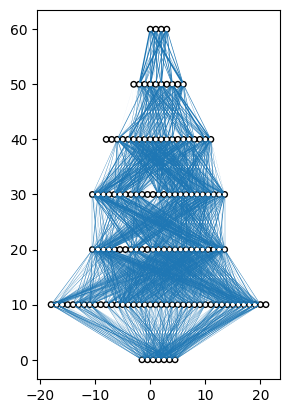

In [28]:
vertical_distance_between_layers = 10
horizontal_distance_between_neurons = 1
neuron_radius = 0.5
number_of_neurons_in_widest_layer = 4

network = NeuralNetwork()

list = clf.coefs_

for index, item in enumerate(list):
    weights = item
    num_nodes = len(item)

    network.add_layer(num_nodes, weights)

network.add_layer(4)
network.draw()